In [1]:
import numpy as np
import pandas as pd
from numpy import pi
import qiskit
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info.random.utils import random_state
from random import randint
from qiskit.providers.aer import noise
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
from qiskit.quantum_info.operators import Operator, Pauli

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
# imports IBMQ backends
from qiskit.providers.ibmq import IBMQ
from qiskit.providers.aqt import AQT
aqt_provider_simulators = AQT.enable_account('2633b2d14dae4d9da7c9df2503857334')
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmq_16_melbourne') #ibmq_burlington ibmq_16_melbourne
aqt_device = aqt_provider_simulators.get_backend('aqt_qasm_simulator_noise_1')
backend_IBMQ = ibmq_provider.get_backend('ibmqx2')
properties = backend_IBMQ.properties()
noise_model = noise.device.basic_device_noise_model(properties)
coupling_map = backend_IBMQ.configuration().coupling_map
basis_gates = noise_model.basis_gates

C:\Users\Niels\Envs\dev_qiskit\lib\site-packages\qiskit\providers\aer\noise\device\basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


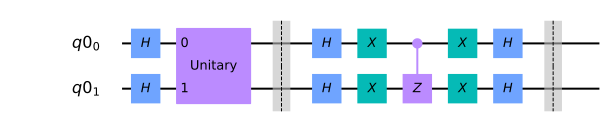

In [2]:
dim = 2
z= QuantumRegister(dim)
qc_expected = QuantumCircuit(z)
qc_expected.h(range(dim))
qreg = QuantumCircuit(z)
# creating a randomized Grover operator
a = randint(0,2**dim-1)
A = np.identity(2**dim)
A[a,a] = -1
print(A)
Grov = Operator(A)
qc_expected.append(Grov,range(dim))

qc_expected.barrier()
# defining the operator to implement inversion about the mean
#MeanInv = 0.5*np.ones((4,4),float)
#np.fill_diagonal(MeanInv,-0.5)
#MeanInv = Operator(MeanInv)
#qc.append(MeanInv,[0,1])
qc_expected.h(range(dim))
qc_expected.x(range(dim))

qc_expected.cz(0,1)
#qc.h(dim-1)
#qc.cccx(0,1,2,3)
#qc.h(dim-1)
qc_expected.x(range(dim))
qc_expected.h(range(dim))
qc_expected.barrier()
#qc.measure(range(dim),range(dim))
qc_expected.draw(output='mpl')

The expected state is: [ 0.+8.71576399e-33j -1.+2.44929360e-16j  0.+8.71576399e-33j
  0.-1.22464680e-16j]


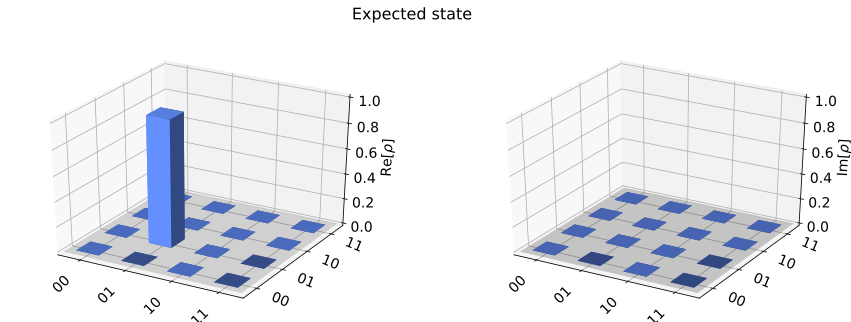

In [3]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
#job = qiskit.execute(qc_expected, simulator, shots=1000)
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')
#control_qubits = [z[0], z[1]]
#qc_expected2=state_tomography_circuits(qc_expected,control_qubits)
#fitter = StateTomographyFitter(job.result(), qc_expected2)

In [4]:
backends = [simulator, device]
bits = ['10', '00', '11', '01']
paulis = [('X','X'),('X','Y'),('X','Z'),
          ('Y','X'),('Y','Y'),('Y','Z'),
          ('Z','X'),('Z','Y'),('Z','Z')]
for be in backends:
    state = {'XX': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'YX': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'ZX': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'XY': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'YY': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'ZY': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'XZ': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'YZ': {'00': 0, '10': 0,'01': 0, '11': 0}, 
             'ZZ': {'00': 0, '10': 0,'01': 0, '11': 0}}
    qst_circuit = state_tomography_circuits(qc_expected,z)
    job = qiskit.execute(qst_circuit, be, shots=1000)
    print('Done job.')
    if be == device:
        job_monitor(job)
    tom = StateTomographyFitter(job.result(), qst_circuit)
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit]=0
    state.update({'XX': {'00': state['XX']['00']+tom.data[('X','X')]['00'],
                                '10': state['XX']['10']+tom.data[('X','X')]['10'],
                                '01': state['XX']['01']+tom.data[('X','X')]['01'],
                                '11': state['XX']['11']+tom.data[('X','X')]['11']}})
    state.update({'YX': {'00': state['YX']['00']+tom.data[('Y','X')]['00'],
                                '10': state['YX']['10']+tom.data[('Y','X')]['10'],
                                '01': state['YX']['01']+tom.data[('Y','X')]['01'],
                                '11': state['YX']['11']+tom.data[('Y','X')]['11']}})
    state.update({'ZX': {'00': state['ZX']['00']+tom.data[('Z','X')]['00'],
                                '10': state['ZX']['10']+tom.data[('Z','X')]['10'],
                                '01': state['ZX']['01']+tom.data[('Z','X')]['01'],
                                '11': state['ZX']['11']+tom.data[('Z','X')]['11']}})
    state.update({'XY': {'00': state['XY']['00']+tom.data[('X','Y')]['00'],
                                '10': state['XY']['10']+tom.data[('X','Y')]['10'],
                                '01': state['XY']['01']+tom.data[('X','Y')]['01'],
                                '11': state['XY']['11']+tom.data[('X','Y')]['11']}})
    state.update({'YY': {'00': state['YY']['00']+tom.data[('Y','Y')]['00'],
                                '10': state['YY']['10']+tom.data[('Y','Y')]['10'],
                                '01': state['YY']['01']+tom.data[('Y','Y')]['01'],
                                '11': state['YY']['11']+tom.data[('Y','Y')]['11']}})
    state.update({'ZY': {'00': state['ZY']['00']+tom.data[('Z','Y')]['00'],
                                '10': state['ZY']['10']+tom.data[('Z','Y')]['10'],
                                '01': state['ZY']['01']+tom.data[('Z','Y')]['01'],
                                '11': state['ZY']['11']+tom.data[('Z','Y')]['11']}})
    state.update({'XZ': {'00': state['XZ']['00']+tom.data[('X','Z')]['00'],
                                '10': state['XZ']['10']+tom.data[('X','Z')]['10'],
                                '01': state['XZ']['01']+tom.data[('X','Z')]['01'],
                                '11': state['XZ']['11']+tom.data[('X','Z')]['11']}})
    state.update({'YZ': {'00': state['YZ']['00']+tom.data[('Y','Z')]['00'],
                                '10': state['YZ']['10']+tom.data[('Y','Z')]['10'],
                                '01': state['YZ']['01']+tom.data[('Y','Z')]['01'],
                                '11': state['YZ']['11']+tom.data[('Y','Z')]['11']}})
    state.update({'ZZ': {'00': state['ZZ']['00']+tom.data[('Z','Z')]['00'],
                                '10': state['ZZ']['10']+tom.data[('Z','Z')]['10'],
                                '01': state['ZZ']['01']+tom.data[('Z','Z')]['01'],
                                '11': state['ZZ']['11']+tom.data[('Z','Z')]['11']}})
    if be == simulator:
        state_sim = state
        print('The full state for simulator is', state)
    if be == device:
        state_dev = state
        print('The full state for device is', state)

Done job.
The full state for simulator is {'XX': {'00': 253, '10': 260, '01': 229, '11': 258}, 'YX': {'00': 258, '10': 269, '01': 224, '11': 249}, 'ZX': {'00': 0, '10': 0, '01': 485, '11': 515}, 'XY': {'00': 245, '10': 259, '01': 245, '11': 251}, 'YY': {'00': 248, '10': 254, '01': 243, '11': 255}, 'ZY': {'00': 0, '10': 0, '01': 501, '11': 499}, 'XZ': {'00': 533, '10': 0, '01': 467, '11': 0}, 'YZ': {'00': 497, '10': 0, '01': 503, '11': 0}, 'ZZ': {'00': 0, '10': 0, '01': 1000, '11': 0}}
Done job.
Job Status: job has successfully run
The full state for device is {'XX': {'00': 277, '10': 202, '01': 282, '11': 239}, 'YX': {'00': 265, '10': 268, '01': 267, '11': 200}, 'ZX': {'00': 46, '10': 38, '01': 489, '11': 427}, 'XY': {'00': 311, '10': 162, '01': 296, '11': 231}, 'YY': {'00': 331, '10': 201, '01': 282, '11': 186}, 'ZY': {'00': 46, '10': 31, '01': 562, '11': 361}, 'XZ': {'00': 477, '10': 16, '01': 501, '11': 6}, 'YZ': {'00': 509, '10': 10, '01': 466, '11': 15}, 'ZZ': {'00': 50, '10': 14,

In [9]:
# fidelity processing for sim and dev
zero = np.matrix('0,0;0,0')
#Iden = np.matrix('1,0;0,1')
XPaul = np.matrix('0,1;1,0')
YPaul = np.matrix('0,0-1j;0+1j,0')
ZPaul = np.matrix('1,0;0,-1')
XXPaul = np.matrix('0,0,0,1;0,0,1,0;0,1,0,0;1,0,0,0')
XYPaul = np.matrix('0,0,0,0-1j;0,0,0+1j,0;0,0-1j,0,0;0+1j,0,0,0')
XZPaul = np.matrix('0,0,1,0;0,0,0,-1;1,0,0,0;0,-1,0,0')

Iden = np.matrix('1,0,0,0;0,1,0,0;0,0,1,0;0,0,0,1')

YXPaul = np.matrix('0,0,0,0-1j;0,0,0-1j,0;0,0+1j,0,0;0+1j,0,0,0')
YYPaul = np.matrix('0,0,0,-1;0,0,1,0;0,1,0,0;-1,0,0,0')
YZPaul = np.matrix('0,0,0-1j,0;0,0,0,0+1j;0+1j,0,0,0;0,0-1j,0,0')

ZXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,-1;0,0,-1,0')
ZYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0+1j;0,0,0-1j,0')
ZZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,-1,0;0,0,0,1')

IXPaul = np.matrix('0,1,0,0;1,0,0,0;0,0,0,1;0,0,1,0')
IYPaul = np.matrix('0,0-1j,0,0;0+1j,0,0,0;0,0,0,0-1j;0,0,0+1j,0')
IZPaul = np.matrix('1,0,0,0;0,-1,0,0;0,0,1,0;0,0,0,-1')
XIPaul = np.matrix('0,0,1,0;0,0,0,1;1,0,0,0;0,1,0,0')
YIPaul = np.matrix('0,0,0-1j,0;0,0,0,0-1j;0+1j,0,0,0;0,0+1j,0,0')
ZIPaul = np.matrix('1,0,0,0;0,1,0,0;0,0,-1,0;0,0,0,-1')

# simulator Bloch vector
rxx_sim = (state_sim['XX']['00']*1 + state_sim['XX']['10']*(-1)+state_sim['XX']['01']*(-1)+state_sim['XX']['11']*1) /(state_sim['XX']['00']*1 + state_sim['XX']['10']*(1)+state_sim['XX']['01']*(1)+state_sim['XX']['11']*1)
rxy_sim = (state_sim['XY']['00']*1 + state_sim['XY']['10']*(-1)+state_sim['XY']['01']*(-1)+state_sim['XY']['11']*1) /(state_sim['XY']['00']*1 + state_sim['XY']['10']*(1)+state_sim['XY']['01']*(1)+state_sim['XY']['11']*1)
rxz_sim = (state_sim['XZ']['00']*1 + state_sim['XZ']['10']*(-1)+state_sim['XZ']['01']*(-1)+state_sim['XZ']['11']*1) /(state_sim['XZ']['00']*1 + state_sim['XZ']['10']*(1)+state_sim['XZ']['01']*(1)+state_sim['XZ']['11']*1)
ryx_sim = (state_sim['YX']['00']*1 + state_sim['YX']['10']*(-1)+state_sim['YX']['01']*(-1)+state_sim['YX']['11']*1) /(state_sim['YX']['00']*1 + state_sim['YX']['10']*(1)+state_sim['YX']['01']*(1)+state_sim['YX']['11']*1)
ryy_sim = (state_sim['YY']['00']*1 + state_sim['YY']['10']*(-1)+state_sim['YY']['01']*(-1)+state_sim['YY']['11']*1) /(state_sim['YY']['00']*1 + state_sim['YY']['10']*(1)+state_sim['YY']['01']*(1)+state_sim['YY']['11']*1)
ryz_sim = (state_sim['YZ']['00']*1 + state_sim['YZ']['10']*(-1)+state_sim['YZ']['01']*(-1)+state_sim['YZ']['11']*1) /(state_sim['YZ']['00']*1 + state_sim['YZ']['10']*(1)+state_sim['YZ']['01']*(1)+state_sim['YZ']['11']*1)
rzx_sim = (state_sim['ZX']['00']*1 + state_sim['ZX']['10']*(-1)+state_sim['ZX']['01']*(-1)+state_sim['ZX']['11']*1) /(state_sim['ZX']['00']*1 + state_sim['ZX']['10']*(1)+state_sim['ZX']['01']*(1)+state_sim['ZX']['11']*1)
rzy_sim = (state_sim['ZY']['00']*1 + state_sim['ZY']['10']*(-1)+state_sim['ZY']['01']*(-1)+state_sim['ZY']['11']*1) /(state_sim['ZY']['00']*1 + state_sim['ZY']['10']*(1)+state_sim['ZY']['01']*(1)+state_sim['ZY']['11']*1)
rzz_sim = (state_sim['ZZ']['00']*1 + state_sim['ZZ']['10']*(-1)+state_sim['ZZ']['01']*(-1)+state_sim['ZZ']['11']*1) /(state_sim['ZZ']['00']*1 + state_sim['ZZ']['10']*(1)+state_sim['ZZ']['01']*(1)+state_sim['ZZ']['11']*1)

rix_sim = (state_sim['XX']['00']*1 + state_sim['XX']['10']*(1)+state_sim['XX']['01']*(-1)+state_sim['XX']['11']*(-1)) /(state_sim['XX']['00']*1 + state_sim['XX']['10']*(1)+state_sim['XX']['01']*(1)+state_sim['XX']['11']*1)
rxi_sim = (state_sim['XX']['00']*1 + state_sim['XX']['10']*(-1)+state_sim['XX']['01']*(1)+state_sim['XX']['11']*(-1)) /(state_sim['XX']['00']*1 + state_sim['XX']['10']*(1)+state_sim['XX']['01']*(1)+state_sim['XX']['11']*1)

riy_sim = (state_sim['YY']['00']*1 + state_sim['YY']['10']*(1)+state_sim['YY']['01']*(-1)+state_sim['YY']['11']*(-1)) /(state_sim['YY']['00']*1 + state_sim['YY']['10']*(1)+state_sim['YY']['01']*(1)+state_sim['YY']['11']*1)
ryi_sim = (state_sim['YY']['00']*1 + state_sim['YY']['10']*(-1)+state_sim['YY']['01']*(1)+state_sim['YY']['11']*(-1)) /(state_sim['YY']['00']*1 + state_sim['YY']['10']*(1)+state_sim['YY']['01']*(1)+state_sim['YY']['11']*1)

riz_sim = (state_sim['ZZ']['00']*1 + state_sim['ZZ']['10']*(1)+state_sim['ZZ']['01']*(-1)+state_sim['ZZ']['11']*(-1)) /(state_sim['ZZ']['00']*1 + state_sim['ZZ']['10']*(1)+state_sim['ZZ']['01']*(1)+state_sim['ZZ']['11']*1)
rzi_sim = (state_sim['ZZ']['00']*1 + state_sim['ZZ']['10']*(-1)+state_sim['ZZ']['01']*(1)+state_sim['ZZ']['11']*(-1)) /(state_sim['ZZ']['00']*1 + state_sim['ZZ']['10']*(1)+state_sim['ZZ']['01']*(1)+state_sim['ZZ']['11']*1)

rho_sim = (1/4)*(Iden+rxx_sim*XXPaul+rxy_sim*XYPaul+rxz_sim*XZPaul+
                 ryx_sim*YXPaul+ryy_sim*YYPaul+ryz_sim*YZPaul+
                 rzx_sim*ZXPaul+rzy_sim*ZYPaul+rzz_sim*ZZPaul+
                rix_sim*IXPaul+rxi_sim*XIPaul+riy_sim*IYPaul+ryi_sim*YIPaul+riz_sim*IZPaul+rzi_sim*ZIPaul)

rxx_dev = (state_dev['XX']['00']*1 + state_dev['XX']['10']*(-1)+state_dev['XX']['01']*(-1)+state_dev['XX']['11']*1) /(state_dev['XX']['00']*1 + state_dev['XX']['10']*(1)+state_dev['XX']['01']*(1)+state_dev['XX']['11']*1)
rxy_dev = (state_dev['XY']['00']*1 + state_dev['XY']['10']*(-1)+state_dev['XY']['01']*(-1)+state_dev['XY']['11']*1) /(state_dev['XY']['00']*1 + state_dev['XY']['10']*(1)+state_dev['XY']['01']*(1)+state_dev['XY']['11']*1)
rxz_dev = (state_dev['XZ']['00']*1 + state_dev['XZ']['10']*(-1)+state_dev['XZ']['01']*(-1)+state_dev['XZ']['11']*1) /(state_dev['XZ']['00']*1 + state_dev['XZ']['10']*(1)+state_dev['XZ']['01']*(1)+state_dev['XZ']['11']*1)
ryx_dev = (state_dev['YX']['00']*1 + state_dev['YX']['10']*(-1)+state_dev['YX']['01']*(-1)+state_dev['YX']['11']*1) /(state_dev['YX']['00']*1 + state_dev['YX']['10']*(1)+state_dev['YX']['01']*(1)+state_dev['YX']['11']*1)
ryy_dev = (state_dev['YY']['00']*1 + state_dev['YY']['10']*(-1)+state_dev['YY']['01']*(-1)+state_dev['YY']['11']*1) /(state_dev['YY']['00']*1 + state_dev['YY']['10']*(1)+state_dev['YY']['01']*(1)+state_dev['YY']['11']*1)
ryz_dev = (state_dev['YZ']['00']*1 + state_dev['YZ']['10']*(-1)+state_dev['YZ']['01']*(-1)+state_dev['YZ']['11']*1) /(state_dev['YZ']['00']*1 + state_dev['YZ']['10']*(1)+state_dev['YZ']['01']*(1)+state_dev['YZ']['11']*1)
rzx_dev = (state_dev['ZX']['00']*1 + state_dev['ZX']['10']*(-1)+state_dev['ZX']['01']*(-1)+state_dev['ZX']['11']*1) /(state_dev['ZX']['00']*1 + state_dev['ZX']['10']*(1)+state_dev['ZX']['01']*(1)+state_dev['ZX']['11']*1)
rzy_dev = (state_dev['ZY']['00']*1 + state_dev['ZY']['10']*(-1)+state_dev['ZY']['01']*(-1)+state_dev['ZY']['11']*1) /(state_dev['ZY']['00']*1 + state_dev['ZY']['10']*(1)+state_dev['ZY']['01']*(1)+state_dev['ZY']['11']*1)
rzz_dev = (state_dev['ZZ']['00']*1 + state_dev['ZZ']['10']*(-1)+state_dev['ZZ']['01']*(-1)+state_dev['ZZ']['11']*1) /(state_dev['ZZ']['00']*1 + state_dev['ZZ']['10']*(1)+state_dev['ZZ']['01']*(1)+state_dev['ZZ']['11']*1)

rix_dev = (state_dev['XX']['00']*1 + state_dev['XX']['10']*(1)+state_dev['XX']['01']*(-1)+state_dev['XX']['11']*(-1)) /(state_dev['XX']['00']*1 + state_dev['XX']['10']*(1)+state_dev['XX']['01']*(1)+state_dev['XX']['11']*1)
rxi_dev = (state_dev['XX']['00']*1 + state_dev['XX']['10']*(-1)+state_dev['XX']['01']*(1)+state_dev['XX']['11']*(-1)) /(state_dev['XX']['00']*1 + state_dev['XX']['10']*(1)+state_dev['XX']['01']*(1)+state_dev['XX']['11']*1)

riy_dev = (state_dev['YY']['00']*1 + state_dev['YY']['10']*(1)+state_dev['YY']['01']*(-1)+state_dev['YY']['11']*(-1)) /(state_dev['YY']['00']*1 + state_dev['YY']['10']*(1)+state_dev['YY']['01']*(1)+state_dev['YY']['11']*1)
ryi_dev = (state_dev['YY']['00']*1 + state_dev['YY']['10']*(-1)+state_dev['YY']['01']*(1)+state_dev['YY']['11']*(-1)) /(state_dev['YY']['00']*1 + state_dev['YY']['10']*(1)+state_dev['YY']['01']*(1)+state_dev['YY']['11']*1)

riz_dev = (state_dev['ZZ']['00']*1 + state_dev['ZZ']['10']*(1)+state_dev['ZZ']['01']*(-1)+state_dev['ZZ']['11']*(-1)) /(state_dev['ZZ']['00']*1 + state_dev['ZZ']['10']*(1)+state_dev['ZZ']['01']*(1)+state_dev['ZZ']['11']*1)
rzi_dev = (state_dev['ZZ']['00']*1 + state_dev['ZZ']['10']*(-1)+state_dev['ZZ']['01']*(1)+state_dev['ZZ']['11']*(-1)) /(state_dev['ZZ']['00']*1 + state_dev['ZZ']['10']*(1)+state_dev['ZZ']['01']*(1)+state_dev['ZZ']['11']*1)


rho_dev = (1/4)*(Iden+rxx_dev*XXPaul+rxy_dev*XYPaul+rxz_dev*XZPaul+
                 ryx_dev*YXPaul+ryy_dev*YYPaul+ryz_dev*YZPaul+
                rzx_dev*ZXPaul+rzy_dev*ZYPaul+rzz_dev*ZZPaul+
                rix_dev*IXPaul+rxi_dev*XIPaul+riy_dev*IYPaul+ryi_dev*YIPaul+riz_dev*IZPaul+rzi_dev*ZIPaul)

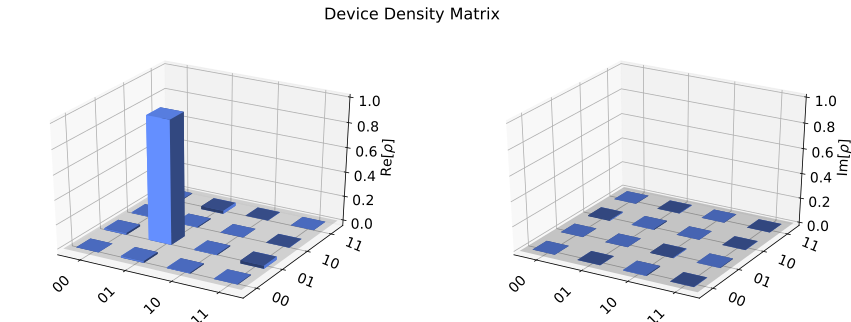

In [10]:
plot_state_city(rho_sim, title='Device Density Matrix')


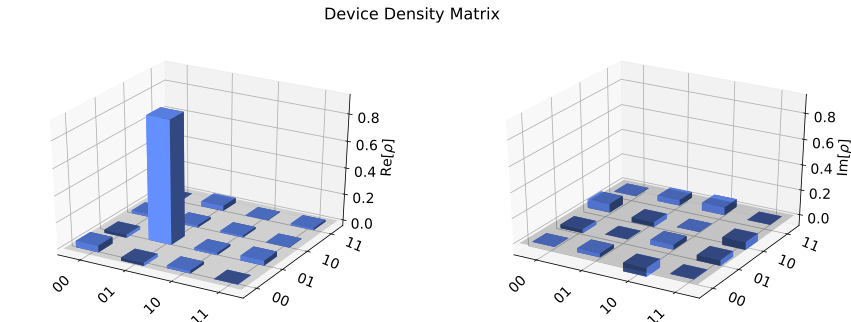

In [11]:
plot_state_city(rho_dev, title='Device Density Matrix')


In [12]:
Dev_Fidelity = state_fidelity(psi_expected, rho_dev, validate=False)
print('Device Fidelity:', Dev_Fidelity)

Device Fidelity: 0.9220000000000004
